In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import torch
import torchvision
import numpy as np
from nilearn import plotting
import clinicadl
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import log_loss
from collections import OrderedDict
from PIL import Image
from tqdm import tqdm
from math import floor
import pickle
import random

# torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# clinicaDL
from clinicadl.tools.tsv.data_split import create_split
from clinicadl.tools.deep_learning.data import generate_sampler, return_dataset, MRIDataset, MRIDatasetImage, MRIDatasetSlice, get_transforms
from torch.utils.data import DataLoader
from clinicadl.tools.deep_learning.cnn_utils import train, get_criterion, test
from clinicadl.tools.deep_learning.models.random import RandomArchitecture
from clinicadl.tools.deep_learning import EarlyStopping

In [5]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [24]:
from tools.explanations.evaluation import *
from tools.explanations.GradCam import *
from train.train_CNN import *
from tools.callbacks import *

In [7]:
data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'
df_data = pd.read_csv(data_path,sep='\t',nrows=10)
df_summary = pd.read_csv(summary_path,sep='\t',nrows=10)

In [8]:
file = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI052S1251/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI052S1251_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'
ts = torch.load(file)
ts.shape

torch.Size([1, 169, 208, 179])

In [9]:
input_type = ''
network_type = ''
caps_directory = ''
preprocessing = ''
tsv_path = ''

# Iterator

In [10]:
def fetch_add_data(training_data, pipeline_name = 't1-volume',atlas_id = 'AAL2'):
    """
    Fetch additional data: age, sex and volumes.
    Normalize scalar data.
    """
    # paths
    data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
    summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'

    # fetch indexes
    df_summary = pd.read_csv(summary_path,sep='\t')
    df_summary = df_summary[(df_summary.pipeline_name == pipeline_name) & (df_summary.atlas_id == atlas_id)]
    first_column_index = df_summary.first_column_index.item()
    last_column_index = df_summary.last_column_index.item()
    
    # other data to fetch
    df_data = pd.read_csv(data_path, sep='\t', nrows=1)
    col_names = ['participant_id', 'session_id', 'sex', 'age']
    add_indexes = [df_data.columns.get_loc(col_name) for col_name in col_names]
    
    # compute df_add_data
    df_add_data = pd.read_csv(data_path,sep='\t', usecols=np.hstack([add_indexes, \
            np.arange(first_column_index,last_column_index+1)]).flatten()).dropna(axis=1,how='all')
    
    # normalization
    temp_df = pd.merge(training_data[['participant_id', 'session_id']], 
                  df_add_data, on=['participant_id', 'session_id'], how='left')
    scalar_cols = temp_df.columns.difference(['participant_id', 'session_id', 'sex'])
    df_add_data[scalar_cols] = (df_add_data[scalar_cols] - temp_df.mean())/temp_df.std()
    
    
    return df_add_data

In [11]:
class MRIDatasetSlice(MRIDataset):

    def __init__(self, caps_directory, data_file, slice_index=None, preprocessing="t1-linear",
                 train_transformations=None, mri_plane=0, prepare_dl=False,
                 discarded_slices=20, mixed=False, labels=True, all_transformations=None,
                 multi_cohort=False,
                 df_add_data=None):
        """
        Args:
            caps_directory (string): Directory of all the images.
            data_file (string or DataFrame): Path to the tsv file or DataFrame containing the subject/session list.
            preprocessing (string): Defines the path to the data in CAPS.
            slice_index (int, optional): If a value is given the same slice will be extracted for each image.
                else the dataset will load all the slices possible for one image.
            train_transformations (callable, optional): Optional transform to be applied only on training mode.
            prepare_dl (bool): If true pre-extracted patches will be loaded.
            mri_plane (int): Defines which mri plane is used for slice extraction.
            discarded_slices (int or list): number of slices discarded at the beginning and the end of the image.
                If one single value is given, the same amount is discarded at the beginning and at the end.
            mixed (bool): If True will look for a 'slice_id' column in the input DataFrame to load each slice
                independently.
            labels (bool): If True the diagnosis will be extracted from the given DataFrame.
            all_transformations (callable, options): Optional transform to be applied during training and evaluation.
            multi_cohort (bool): If True caps_directory is the path to a TSV file linking cohort names and paths.
            df_add_data (DataFrame): dataframe containing additional data to predict, such as volumes
            training_data_file: dataframe containing the subject/session list for training. 
                If None, data_file is selected as training_data_file
        """
        # additional data
        self.df_add_data = df_add_data
        
        # Rename MRI plane
        if preprocessing == "shepplogan":
            raise ValueError("Slice mode is not available for preprocessing %s" % preprocessing)
        self.elem_index = slice_index
        self.mri_plane = mri_plane
        self.direction_list = ['sag', 'cor', 'axi']
        if self.mri_plane >= len(self.direction_list):
            raise ValueError(
                "mri_plane value %i > %i" %
                (self.mri_plane, len(
                    self.direction_list)))

        # Manage discarded_slices
        if isinstance(discarded_slices, int):
            discarded_slices = [discarded_slices, discarded_slices]
        if isinstance(discarded_slices, list) and len(discarded_slices) == 1:
            discarded_slices = discarded_slices * 2
        self.discarded_slices = discarded_slices

        if mixed:
            self.elem_index = "mixed"
        else:
            self.elem_index = None

        self.mode = "slice"
        self.prepare_dl = prepare_dl
        super().__init__(caps_directory, data_file, preprocessing,
                         augmentation_transformations=train_transformations, labels=labels,
                         transformations=all_transformations, multi_cohort=multi_cohort)
        

    def __getitem__(self, idx):
        participant, session, cohort, slice_idx, label = self._get_meta_data(idx)
        slice_idx = slice_idx + self.discarded_slices[0]

        if self.prepare_dl:
            # read the slices directly
            slice_path = path.join(self._get_path(participant, session, cohort, "slice")[0:-7]
                                   + '_axis-%s' % self.direction_list[self.mri_plane]
                                   + '_channel-rgb_slice-%i_T1w.pt' % slice_idx)
            image = torch.load(slice_path)
        else:
            image_path = self._get_path(participant, session, cohort, "image")
            full_image = torch.load(image_path)
            image = self.extract_slice_from_mri(full_image, slice_idx)

        if self.transformations:
            image = self.transformations(image)

        if self.augmentation_transformations and not self.eval_mode:
            image = self.augmentation_transformations(image)
            
        ## fetch additional data
        temp_df = self.df_add_data[(self.df_add_data.participant_id == participant) & 
                              (self.df_add_data.session_id == session)]
        sex  = (temp_df.sex.to_numpy().item() == 'F') + 0.
        age  = temp_df.age.to_numpy().item()
        volumes = temp_df.drop(columns=['participant_id', 'session_id', 'sex', 'age']).to_numpy().squeeze()

        sample = {'image': image, 'label': label,
                  'participant_id': participant, 'session_id': session,
                  'slice_id': slice_idx, 'age': age, 'sex': sex, 'volumes': volumes}

        return sample

    def num_elem_per_image(self):
        if self.elem_index is not None:
            return 1

        image = self._get_full_image()
        return image.size(self.mri_plane + 1) - \
            self.discarded_slices[0] - self.discarded_slices[1]
    
    def extract_slice_from_mri(self, image, index_slice):
        """
        This is a function to grab one slice in each view and create a rgb image for transferring learning: duplicate the slices into R, G, B channel
        :param image: (tensor)
        :param index_slice: (int) index of the wanted slice
        :return:
        To note, for each view:
        Axial_view = "[:, :, slice_i]"
        Coronal_view = "[:, slice_i, :]"
        Sagittal_view= "[slice_i, :, :]"
        """
        image = image.squeeze(0)
        simple_slice = image[(slice(None),) * self.mri_plane + (index_slice,)]
        triple_slice = torch.stack((simple_slice, simple_slice, simple_slice))

        return triple_slice

# Models

In [12]:
class Net(nn.Module):
    def __init__(self, sample, convolutions):
        super().__init__()
        self.image_size = sample['image'].shape
        self.features = nn.Sequential()
        input_size = self.image_size[0]
        h_w = self.image_size[1:]
        
        # default parameters
        kernel_size = 3
        
        for index, nb_conv in enumerate(convolutions):
            self.features.add_module('conv' + str(index), nn.Conv2d(input_size, nb_conv, kernel_size))
            h_w = self.conv_output_shape(h_w, 3)
            self.features.add_module('relu' + str(index), nn.ReLU())
            self.features.add_module('bnn' + str(index), nn.BatchNorm2d(nb_conv))
            self.features.add_module('pool' + str(index), nn.MaxPool2d(2,2))
            h_w = self.conv_output_shape(h_w, 2, stride=2)
            input_size = nb_conv
            
        
        self.features_output_size = np.prod(h_w) * nb_conv
        self.dense_size_1 = 32
        self.dense_size_2 = 16
        
        # classifyer
        self.branch1 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_size_1),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_1),
            nn.Linear(self.dense_size_1, self.dense_size_2),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_2),
            nn.Linear(self.dense_size_2, 1),
            nn.Sigmoid()
        )
        # volumes
        n_volumes = np.prod(sample['volumes'].shape)
        self.branch2 = nn.Sequential(
            nn.Linear(self.features_output_size, 4*n_volumes),
            nn.ReLU(),
            nn.BatchNorm1d(4*n_volumes),
            nn.Linear(4*n_volumes, 2*n_volumes),
            nn.ReLU(),
            nn.BatchNorm1d(2*n_volumes),
            nn.Linear(2*n_volumes, n_volumes)
        )
        # age
        self.branch3 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_size_1),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_1),
            nn.Linear(self.dense_size_1, self.dense_size_2),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_2),
            nn.Linear(self.dense_size_2, 1)
        )
        # sex
        self.branch4 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_size_1),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_1),
            nn.Linear(self.dense_size_1, self.dense_size_2),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_2),
            nn.Linear(self.dense_size_2, 1),
            nn.Sigmoid()
        )
    
    @staticmethod
    def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size)
        h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
        w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
        return h, w
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.features_output_size)
        c = self.branch1(x)
        v = self.branch2(x)
        age = self.branch3(x)
        sex = self.branch4(x)
        return c, v, age, sex
    
    def summary(self):
        """
        Print a summary of the model.
        """
        summary(self, input_size=self.image_size)


# Utils

# Train Single CNN

## Initialization

In [15]:
# global parameters
caps_directory = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/'
batch_size = 512
num_workers = 1
loss = 'default'
optimizer_name = 'Adam'
learning_rate = 1e-4
weight_decay = 1e-4

In [16]:
# fold iterator
fold_iterator = range(2)

# load dataframes
AD = pd.read_csv('subjects/AD.tsv',sep='\t')
CN = pd.read_csv('subjects/CN.tsv',sep='\t')

# remove samples with NaN
AD.drop(AD[AD.isna().sum(axis=1) > 0].index, inplace=True)
CN.drop(CN[CN.isna().sum(axis=1) > 0].index, inplace=True)

# split data between training and validation sets
training_df, valid_df = create_split('AD', AD, 'diagnosis',0.2)
df_CN = create_split('CN', CN, 'diagnosis',0.2)
training_df = training_df.append(df_CN[0]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]
valid_df = valid_df.append(df_CN[1]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]

# drop index column
training_df.drop(columns = ['index'], inplace=True)
valid_df.drop(columns = ['index'], inplace=True)

train_transforms, all_transforms = get_transforms('image',
                                                  minmaxnormalization=False,
                                                  data_augmentation=None )
# fetch volumetric data
df_add_data = fetch_add_data(training_df)

# all_transforms = torchvision.transforms.Compose([])

DEBUG:root:p_age=0.87, p_sex=0.8941
INFO:root:Split for diagnosis AD was found after 1 trials
DEBUG:root:p_age=0.51, p_sex=0.7593
DEBUG:root:p_age=0.74, p_sex=0.9547
DEBUG:root:p_age=0.42, p_sex=0.9547
DEBUG:root:p_age=0.15, p_sex=0.9954
DEBUG:root:p_age=0.87, p_sex=0.9547
INFO:root:Split for diagnosis CN was found after 5 trials


In [17]:
# follow structure of ``train_single_cnn``

# training_df['slice_id'] = 85
# valid_df['slice_id'] = 85
# dataset iterator
# data_train = MRIDatasetSlice(caps_directory, training_df, slice_index=85, mixed=True, df_add_data=df_add_data) #train_transformations=all_transforms
# data_valid = MRIDatasetSlice(caps_directory, valid_df, slice_index=85, mixed=True, df_add_data=df_add_data) #train_transformations=all_transforms,

data_train = MRIDatasetSlice(caps_directory, training_df, df_add_data=df_add_data) #train_transformations=all_transforms
data_valid = MRIDatasetSlice(caps_directory, valid_df, df_add_data=df_add_data) #train_transformations=all_transforms,


# sampler
train_sampler = generate_sampler(data_train)
valid_sampler = generate_sampler(data_valid)
# loaders
train_loader = DataLoader(data_train,
                         batch_size=batch_size,
                         sampler=train_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

valid_loader = DataLoader(data_valid,
                         batch_size=batch_size,
                         sampler=valid_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

## Training

In [18]:
# get sample
sample = data_train[0]
# build model
model = Net(sample, [8, 16, 32, 64, 128])
if torch.cuda.is_available():
    print("To cuda")
    model.cuda()
model.summary()

To cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 206, 177]             224
              ReLU-2          [-1, 8, 206, 177]               0
       BatchNorm2d-3          [-1, 8, 206, 177]              16
         MaxPool2d-4           [-1, 8, 103, 88]               0
            Conv2d-5          [-1, 16, 101, 86]           1,168
              ReLU-6          [-1, 16, 101, 86]               0
       BatchNorm2d-7          [-1, 16, 101, 86]              32
         MaxPool2d-8           [-1, 16, 50, 43]               0
            Conv2d-9           [-1, 32, 48, 41]           4,640
             ReLU-10           [-1, 32, 48, 41]               0
      BatchNorm2d-11           [-1, 32, 48, 41]              64
        MaxPool2d-12           [-1, 32, 24, 20]               0
           Conv2d-13           [-1, 64, 22, 18]          18,496
             ReLU-14           

In [19]:
# nb_epochs = 20
# # optimizer
# optimizer = optim.Adam(model.parameters(),lr=learning_rate)
# # device
# cuda = torch.device('cuda')
# # record losses
# train_losses = {
#     'classification': np.zeros(nb_epochs),
#     'volumes': np.zeros(nb_epochs),
#     'age': np.zeros(nb_epochs),
#     'sex': np.zeros(nb_epochs),
#     'train': np.zeros(nb_epochs)
# }
# test_losses = {
#     'classification': np.zeros(nb_epochs),
#     'volumes': np.zeros(nb_epochs),
#     'age': np.zeros(nb_epochs),
#     'sex': np.zeros(nb_epochs),
#     'test': np.zeros(nb_epochs)
# }

# # callbacks
# ES = EarlyStopping(patience=5)
# MC = ModelCheckpoint()

# # training
# for epoch in range(nb_epochs):
#     update_dict(train_losses, train(epoch, model, optimizer, cuda, train_loader), epoch)
#     update_dict(test_losses, test(model, cuda, valid_loader), epoch)
#     if ES.step(train_losses['train'][epoch]):
#         break
#     MC.step(train_losses['train'][epoch], epoch, model, optimizer) # path

# # save training curves
# f = open("train_losses.pkl","wb")
# pickle.dump(train_losses,f)
# f.close()

# f = open("val_losses.pkl","wb")
# pickle.dump(test_losses,f)
# f.close()

## Visualization

In [20]:
def plot_losses(dict_losses, title=""):
    """
    Plot the different losses.
    
    Args:
        dict_losses: dictionnary of losses
    """
    plt.figure()
    plt.title(title)
    for key in dict_losses.keys():
        plt.plot(dict_losses[key], label=key)
    plt.legend()
    plt.show()
    
def plot_tensor(X):
    x = np.transpose(X[0], (1,2,0))
    x = (x-x.min())/x.max()
    plt.imshow(x)

In [21]:
plot_losses(train_losses, "Training losses")

NameError: name 'train_losses' is not defined

## Assess explanation

In [26]:
# load model
saved_data = torch.load('model_0.pt')

model.load_state_dict(saved_data['model_state_dict'])

<All keys matched successfully>

In [27]:
GC = GradCam(model,'conv4')
img = sample['image'][None,...].float()
img2 = torch.cat((img,img),0)
resu = GC.get_explanations(img2)
#GC.visualize_cams(img)

In [64]:
a,b,c,d = [], [], [], []
n_max = 500
step = 20
for k in range(1, n_max, step):
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    resu = max_sensitivity(img, GC, k)
    a.append(resu['branch1'])
    b.append(resu['branch2'])
    c.append(resu['branch3'])
    d.append(resu['branch4'])

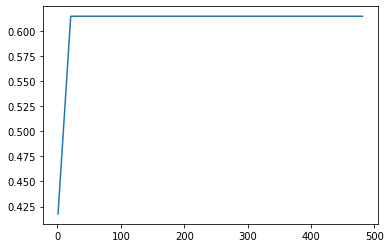

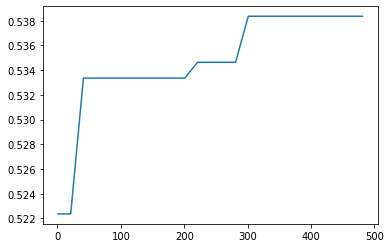

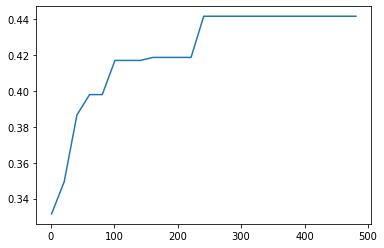

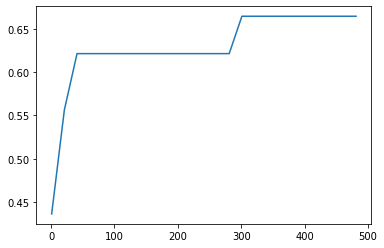

In [65]:
for elem in (a, b, c ,d):
    plt.figure()
    plt.plot(np.arange(1,n_max,step), elem)

In [97]:
attention = GC.generate_cam(img)

In [53]:
ids = np.unravel_index(np.argsort(-attention, axis=None), attention.shape)

In [98]:
at2 = attention.copy()
at2[(ids[0][:5000], ids[1][:5000])] = 0

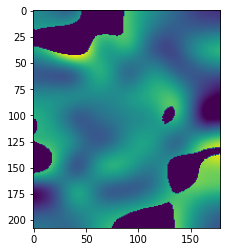

In [100]:
plt.imshow(at2)

In [63]:
img2 = img[0,0,...]
img2[(ids[0][:5000], ids[1][:5000])] = 0

In [71]:
img2[(ids[0][:5000], ids[1][:5000])].shape

torch.Size([5000])

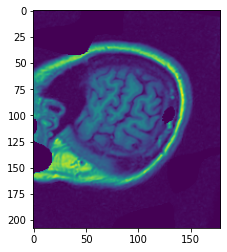

In [64]:
plt.imshow(img2)

In [79]:
import numpy.ma as ma

In [ ]:
def MoRF(X, model, exp_method, K=10, AUC=False, batch_size=512):
    """
    Most relevant first: measures the reliability of an explanation by testing 
    how fast the output decreases, while we progressively remove information (e.g., perturb pixels) 
    from the input 𝑥𝑥 (e.g., image), that appears as the most relevant by the explanation.
    Args:
        X: tensor, brain image, with shape (1, n_channels, **dims)
        exp_method: explanation method. Must have a get_explanations(self, input_image) attribute function
            which takes an image as input and returns a dictionary mapping branches to explanation maps
        K: number of relevant pixels to remove
        AUC: bool. If True: compute and return area under the curve obtained after removing successively 
            the K most relevant pixels.
            
    TO DO:
        - add several methods to pertur pixels
    """
    if torch.cuda.is_available():
        X = X.cuda()

    # explanations for original image
    expls = exp_method.get_explanations(X)
    
    # Indices of the sorted elements of the explanations:
    ind = dict()
    for target in expls:
        ind = np.unravel_index(np.argsort(-expls[target], axis=None), expls.shape)
    
        if AUC:
            pass
        else:
            # compute MoRF removing the K most relevant pixels
            MoRF
            perturbed_X = X.copy()
            perturbed_X[:,:,ind[0][:K],ind[1][:K]] = 0
            
        

# RANDOM

In [33]:
df_add_data[df_add_data.iloc[:,3].isna()].isna().sum(axis=0)

participant_id                                                                                      0
session_id                                                                                          0
sex                                                                                                 1
age                                                                                              1178
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Background_intensity                       1173
                                                                                                 ... 
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Posterior-Orbital-Gyrus_intensity    1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Planum-Polare_intensity               1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Planum-Polare_intensity              1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Precentral-Gyrus_intens

I am using working with the file '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv' and using the 't1-volume' pipeline and the atlas 'AAL2'.
6267 samples (i.e. couples (participant_id, session_id)) do not have any volume value (i.e. NaN). 1 sample has no sex value and 1178 samples have no age values.


In [31]:
df_add_data.isna().sum(axis=0)

participant_id                                                                                      0
session_id                                                                                          0
sex                                                                                                 1
age                                                                                              1178
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Background_intensity                       6267
                                                                                                 ... 
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Posterior-Orbital-Gyrus_intensity    6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Planum-Polare_intensity               6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Planum-Polare_intensity              6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Precentral-Gyrus_intens

In [64]:

# initialize the model
convolutions = {
    'conv0':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':16,
        'd_reduction': "MaxPooling"
    },
    'conv1':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv2':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv3':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':64,
        'd_reduction': "MaxPooling"
    },
    'conv4':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':128,
        'd_reduction': "MaxPooling"
    }
}
model = RandomArchitecture(convolutions,1,data_train.size)


# Define criterion and optimizer
criterion = get_criterion(loss)
optimizer = getattr(torch.optim, optimizer_name)(filter(lambda x: x.requires_grad, model.parameters()),
                                                   lr=learning_rate,
                                                   weight_decay=weight_decay)

In [8]:
class Options:
    def __init__(self):
        self.beginning_epoch = 0
        self.tolerance = 0
        self.patience = 10
        self.epochs = 10
        self.gpu = True
        self.batch_size = 1

In [9]:
train(model, train_loader, valid_loader, criterion, optimizer,False,'log_dir','model_dir', Options())

INFO:root:Beginning epoch 0.


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1625, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1632, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 5

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 566, in __getitem__
    participant, session, cohort, slice_idx, label = self._get_meta_data(idx)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 140, in _get_meta_data
    participant = self.df.loc[image_idx, 'participant_id']
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 889, in __getitem__
    return self._getitem_tuple(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1060, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 807, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1124, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1073, in _get_label
    return self.obj.xs(label, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/generic.py", line 3739, in xs
    loc = index.get_loc(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3082, in get_loc
    raise KeyError(key) from err
KeyError: 5
